# Data Mining Project

## Imports

In [1]:
!pip install mglearn

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
import WikipediaExtraction as we
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import mglearn

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
pd.set_option('mode.chained_assignment', None)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kekko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kekko\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Load datasets

In [2]:
with open('recipe-ingredients-dataset/train.json', 'r') as f:
    txt = f.read()
recipes = pd.DataFrame(json.loads(txt))

groceries = pd.read_csv('groceries/groceries - groceries.csv', delimiter=',')
# Convert Market Basket dataset to arrays
groceries_array = groceries.values

# Remove NaN from baskets_arrays
groceries_array_clean = []
for i in groceries_array:
   groceries_array_clean.append([x for x in i if str(x) !='nan'])

df_groceries_clean = pd.DataFrame()
df_groceries_clean["items"] = groceries_array_clean

#remove first element from list (the number of elements)
for index, row in df_groceries_clean.iterrows():
    row['items'].pop(0)

## Defining structures

In [3]:
stopwords = 'bamboo shoots maple heavy wonton wrappers unflavored gelatin thai shiitake pecan pecans gochujang base \
frozen pastry puff sheets english crã¨me fraã®che chorizo sauherbs chipotle chile chipotles in adobo asafoetida active \
bok choy kalamata sprigs shortening andouille sauherbs cajun seasoning half spray powder noodles sliced cottage parmesan \
pip semi-finished other bottled tropical grape romaine confectioners cloves ground jalapeno black all-purpose kosher green \
large unsalted extra-virgin purple grated dried chopped \
fresh diced minced brown extract dry white yellow boneless skinless breasts breast flat freshly sea dried \
granulated crushed shredded whole halves peeled coarse warm yolks cold flakes whites cooking fat free less sodium \
sliced finely low light cracked spring lean cooked part-skim citrus roasted sliced flank unsweetened sweetened melted fine \
yellow dark smoked toasted crumbles plain evaporated baking firm red 1% low-fat \
reduced-fat italian greek style whole peeled shoulder plain unbleached dry baby and frozen\
button cremini pure reduced steamed nonfat & de medium extra prepared bow-tie'

stopwords_grocery = "shopping bags bottled domestic canned whipped/sour specialty whole brown white semi-finished frozen "

word_dict_grocery = {
    "rolls/buns":"bread",
    "whipped/sour cream": "cream",
    "sausage":"meat",
    "frankfurter":"meat",
    "cream cheese":"cheese",
    "uht-milk":"milk",
    "hamburger meat":"meat",
    "berry":"fruits",
    "butter milk":"butter",
    "hard cheese":"cheese",
    "red/blush wine":"wine",
    "soft cheese":"cheese",
    "processed cheese":"cheese",
    "herb":"herbs",
    "potato products":"potato",
    "spread cheese":"cheese",
    "condensed milk":"milk",
    "mayonnaise":"sauce",
    "chocolate marshmallow":"chocolate",
    "specialty cheese":"cheese",
    "turkey":"meat",
    "sparkling wine":"wine",
    "spice":"herbs",
    "liver loaf":"meat",
    "meat spreads":"meat",
    "ketchup":"sauce",
    "prosecco":"wine",
    "ready soups":"soup",
    "whipped/cream":"cream",
    "sliced cheese":"cheese",
    "herbss":"herbs"
}
word_dict_recipes = {'onions':'onion',
            'olives':'olive',
            'almonds':'almond',
            'ribs':'rib',
            'thighs':'thigh',
            'potatoes':'potato',
            'mushrooms':'mushroom',
            'legs':'leg',
            'carrots':'carrot',
            'wings':'',
            'steaks':'steak',
            'bourbon whiskey':'whiskey',
             'yoghurt':'yogurt',
             'jack daniels':'whiskey',
             'olive oil':'oil',
             'vegetable oil':'oil',
             'chicken thigh':'chicken',
             'sherry vinegar':'vinegar',
             'sesame oil':'oil',
             'chili powder':'chili',
             'cayenne pepper':'pepper',
             'cheddar cheese':'cheese',
             'mozzarella':'cheese',
             'rice vinegar':'vinegar',
             'canola oil':'oil',
             'mozzarella cheese':'cheese',
             'basilico':'herbs',
             'cilantro leaves':'cilandro',
             'tomato paste':'tomato',
             'heavy cream':'cream',
             'wine vinegar':'vinegar',
             'chicken stock':'chicken',
             'leaf parsley':'parsley',
             'bay leaves':'bay',
             'buttermilk':'butter',
             'cumin seed':'cumin',
             'zucchini':'vegetables',
             'plum tomatoes':'tomato',
             'flour tortillas':'tortillas',
             'corn tortillas':'tortillas',
             'bay leaf':'bay',
             'basil leaves':'basil',
             'worcestershire sauce':'sauce',
             'curry powder':'curry',
             'hot sauce':'sauce',
             'peppercorn':'pepper',
             'cinnamon sticks':'cinnamon',
             'cream cheese':'cheese',
             'feta cheese':'cheese',
             'whipping cream':'cream',
             'peanut oil':'oil',
             'bread crumbs':'bread',
             'lemon zest':'lemon',
             'balsamic vinegar':'vinegar',
             'celery ribs':'ribs',
             'orange juice':'juice',
             'dijon mustard':'mustard',
             'sour cream':'cream',
             'ricotta cheese':'cheese',
             'ricotta':'cheese',
             'mustard seeds':'mustard',
             'powdered sugar':'sugar',
             'lime wedges':'lime',
             'sharp cheddar cheese':'cheese',
             'beef broth':'broth',
             'ginger root':'ginger',
             'sweet potatoes':'potato',
             'oyster sauce':'sauce',
             'beansprouts':'bean',
             'cornmeal':'flour',
             'vegetable broth':'broth',
             'cherry tomatoes':'tomato',
             'hoisin sauce':'sauce',
             'chicken thighs':'chicken',
             'coriander seeds':'coriander',
             'enchilada sauce':'sauce',
             'frozen peas':'peas',
             'long-grain rice':'rice',
             'hot water':'water',
             'monterey jack cheese':'cheese',
             'parmigiano reggiano cheese':'cheese',
             'fennel seeds':'fennel',
             'boiling water':'water',
             'condensed milk':'milk',
             'cider vinegar':'vinegar',
             'chicken thigh':'chicken',
             'spaghetti':'pasta',
             'corn meal':'flour',
             'basmati rice':'rice',
             'chile pepper':'pepper',
             'sweet onion':'onion',
             'steak':'meat',
             'tomatillo':'tomato',
             'sage':'herbs',
             'ghee':'butter',
             'hot pepper sauce':'sauce',
             'tortilla chips':'tortilla',
             'serrano chile':'pepper',
             'sriracha':'sauce',
             'long grain rice':'rice',
             'arborio rice':'rice',
             'kidney beans':'bean',
             'curry leaves':'curry',
             'curry paste':'curry',
             'taco seasoning':'sauce',
             'creole seasoning':'creole',
             'prosciutto':'ham',
             'garlic paste':'garlic',
             'corn kernels':'corn',
             'baguette':'bread',
             'pasta sauce':'sauce',
             'saffron threads':'herbs',
             'okra':'vegetables',
             'apple cider vinegar':'vinegar',
             'andouille sausage':'meat',
             'corn syrup':'syrup',
             'russet potatoes':'potato',
             'shaoxing wine':'wine',
             'refried beans':'beans',
             'mint leaves':'mint',
             'frozen spinach':'spinach',
             'chinese five-spice':'herbs',
             'linguine':'pasta',
             'cardamom pods':'herbs',
             'golden raisins':'vegetables',
             'hot pepper':'pepper',
             'monterey jack':'cheese',
             'marinara sauce':'sauce',
             'thyme leaves':'thyme',
             'cornflour': 'flour',
             'soy sauce':'sauce',
             'lemon juice':'juice',
             'chicken broth':'broth',
             'chilies':'chili',
             'lime juice':'juice',
             'bay':'herbs',
             'beans':'bean',
             'paprika':'herbs',
             'fish sauce':'sauce',
             'chees cheese':'cheese',
             'sesame seeds':'sesame',
             'salsa':'tomato',
             'garam masala':'herbs',
             'tomato sauce':'tomato',
             'chili peppers':'chili',
             'sharp cheese':'cheese',
             'sweet potato':'potato',
             'turkey':'meat',
             'sherry':'wine',
             'half half':'',
             'sake':'wine',
             'tomatos':'tomato',
             'chiles':'chili',
             'apple vinegar':'vinegar',
             'russet potato':'potato',
             'star anise':'herbs',
             'french bread':'bread',
             'lettuce leaves':'lettuce',
             'pork tenderloin':'pork',
             'roma tomatoes':'tomato',
             'lemon wedge':'lemon',
             'coconut oil':'oil',
             'lemon peel':'lemon',
             'rice wine':'wine',
             'shiitake mushroom':'mushroom',
             'yukon gold potato':'potato',
             'cilantro sprigs':'cilantro',
             'lasagna':'pasta',
             'bacon slices':'bacon',
             'cannellini beans':'bean',
             'fennel bulb':'fennel',
             'tabasco pepper sauce':'sauce',
             'vegetable stock':'broth',
             'pitted kalamata olives':'olive',
             'pinto beans':'bean',
             'black-eyed peas':'peas',
             'bread flour':'flour',
             'self rising flour':'flour',
             'stewed tomatoes':'tomato',
             'button mushroom':'mushroom',
             'broccoli florets':'vegetables',
             'bread crumb':'bread',
             'provolone cheese':'cheese',
             'semisweet chocolate':'chocolate',
             'vanilla beans':'bean',
             'iceberg lettuce':'lettuce',
             'ice water':'water',
             'miso':'herbs',
             'all purpose flour':'flour',
             'allspice':'herbs',
             'ancho pepper':'pepper',
             'anchovy fillets':'fish',
             'artichoke hearts':'artichoked',
             'asian sauce':'sauce',
             'barbecue sauce':'sauce',
             'beef stock':'beef',
             'bittersweet chocolate':'chocolate',
             'butternut squash':'butter',
             'cake flour':'flour',
             'canned broth':'broth',
             'cannellini bean':'bean',
             'caster sugar':'sugar',
             'catfish fillets':'fish',
             'cayenne':'pepper',
             'celery rib':'rib',
             'cheese, soften':'cheese',
             'chicken ':'chicken',
             'chicken leg':'chicken',
             'chicken pieces':'chicken',
             'chile':'chili',
             'chili oil':'oil',
             'chili paste':'chili',
             'chili pepper':'chili',
             'chili sauce':'sauce',
             'chillies':'chili',
             'chinese wine':'wine',
             'corn oil':'oil',
             'creamy peanut butter':'butter',
             'cream of tartar':'cream',
             'fettuccine':'pasta',
             'firmly packed sugar':'sugar',
             'fontina cheese':'cheese',
             'pastry puff sheets':'pasta',
             'garlic chili sauce':'sauce',
             'ginger paste':'ginger',
             'gingerroot':'ginger',
             'goat cheese':'cheese',
             'granny smith apples':'apple',
             'hard-boiled egg':'egg',
             'heavy cream':'cream',
             'herbs leaves':'herbs',
             'hominy':'corn',
             'ice cubes':'ice',
             'jack cheese':'cheese',
             'jasmine rice':'rice',
             'kernel corn, drain':'corn',
             'lime zest':'lime',
             'leaves':'herbs',
             'mexican cheese blend':'cheese',
             'mexican oregano':'herbs',
             'mushroom caps':'mushroom',
             'non-fat cream':'cream',
             'orange peel':'orange',
             'orange zest':'orange',
             'palm sugar':'sugar',
             'pancetta':'bacon',
             'panko breadcrumbs':'bread',
             'parsley leaves':'parsley',
             'peanut butter':'butter',
             'pecorino romano cheese':'cheese',
             'penne':'pasta',
             'penne pasta':'pasta',
             'pesto':'sauce',
             'pinto bean':'bean',
             'pitted olive':'olive',
             'pizza doughs':'pizza',
             'poblano chili':'chili',
             'poblano peppers':'pepper',
             'pork belly':'pork',
             'pork loin':'pork',
             'pork sauherbss':'pork',
             'queso fresco':'cheese',
             'raisins':'grape',
             'rice flour':'flour',
             'romano cheese':'cheese',
             'salad dressing':'salt',
             'salmon':'fish',
             'salmon fillets':'fish',
             'sauherbs':'herbs',
             'sauherbs casings':'herbs',
             'sauherbss':'herbs',
             'scallops':'meat',
             'seasoned bread':'bread',
             'serrano peppers':'pepper',
             'shrimp':'fish',
             'slivered almond':'almond',
             'snow peas':'peas',
             'soba':'soda',
             'spices':'herbs',
             'spinach leaves':'spinach',
             'sugar pea':'peas',
             'sun-dried tomatoes':'tomato',
             'sweet chili sauce':'sauce',
             'sweet herbs':'herbs',
             'swiss cheese':'cheese',
             'szechwan peppers':'pepper',
             'taco mix':'taco',
             'tarragon':'herbs',
             'tomato purã©e':'tomato',
             'tomato verde':'tomato',
             'tomatoes':'tomato',
             'tortillas':'tortilla',
             'vanilla bean':'bean',
             'vidalia onion':'onion',
             'water chestnuts':'chestnuts',
             'wheat flour':'flour',
             'whipped cream':'cream',
             'chickenpieces': 'chicken',
             'corn starch': 'starch',
             'cheese cheese': 'cheese',
             'rib': 'herbs',
             'clove': 'herbs',
             'mirin': 'wine',
             'ketchup': 'sauce',
             'parsley herbs': 'herbs',
             'lamb': 'meat',
             'radishes': 'vegetables',
             'tumeric': 'herbs',
             'bananas': 'fruits',
             'pasta pasta': 'pasta',
             'apples': 'fruits',
             'herbss': 'herbs',
             'spinach herbs': 'spinach',
             'grits': 'vegetables',
             'fettucine': 'pasta',
             'clam juice': 'juice',
             'cotija': 'cheese',
             'pimentos': 'herbs',
             'garlic sauce': 'sauce',
             'sweet sauce': 'sauce',
             'kaffir lime herbs': 'herbs',
             'marsala wine': 'wine',
             'lump crab meat': 'crab',
             'herbs casings': 'herbs',
             'mayonnaise': 'sauce',
             'pork chops': 'pork',
             'porcini mushroom': 'mushroom',
             'pears': 'fruits',
             'masa harina': 'flour',
             'rosemary': 'herbs',
             'mayonaise': 'sauce',
             'peaches': 'fruits',
             'fish fillets': 'fish',
             'garbanzo bean': 'chickpeas',
             'chickenleg': 'chicken',
             'greens': 'vegetables',
             'turnips': 'vegetables',
             'tomato juice': 'juice',
             'chuck': 'meat',
             'fennel': 'vegetables',
             'cumin': 'herbs',
             'creole': 'vegetables'
            }

## Defining methods

In [4]:
def timer(start,end):
    """Calc slot time
    """
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)

def remove_stop_words(query,stopwords):
    """Return a list of cleaned item from a string
    """
    querywords = query.split()
    results_word = [word.lower() for word in querywords if word.lower() not in stopwords]
    results = ' '.join(results_word)
    return results

def executeStopwords(initialColumn, stopwords):
    """Remove stopwords from a list
    return: a list of cleaned items
    """
    stopwords = stopwords.split(' ')
    
    ingredients_filtered = []

    for i in initialColumn:
        temp_l = []
        for j in i:
            temp_l.append(remove_stop_words(j,stopwords))

        ingredients_filtered.append(temp_l)

    return ingredients_filtered


def remove_empty_strings(l):
    """Remove empty strings
    """
    return [i for i in l if i]

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def replaceLemma(initialColumn):
    """Replacing lemma with token
    return: list of tokened ingredient 
    """
    lemmatizer = WordNetLemmatizer()

    ingredients_filtered_clean = []
    for sentence in initialColumn:
        ingredients_filtered_clean.append([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence])
    return ingredients_filtered_clean

def executeMostCommon(initialColumn):
    """Return 100 most common items from a column
    """
    temp_l = initialColumn
    temp_l = [j for i in temp_l for j in i]
    cnt = Counter(temp_l)

    ing_value_count = cnt.most_common()
    ing_value_count.sort(key= lambda x: x[1], reverse=True)
    ing = [(x,y) for x,y in ing_value_count if y>=100]
    print("Most common elements in {} - {}".format(initialColumn.name,len(ing)))
    return ing

def uniqueElements(initialColumn):
    """Return unique elements in a column
    """
    baskets = list(initialColumn)
    unique_mb = set(x for l in baskets for x in l)
    print("Unique elements in {} - {}".format(initialColumn.name,len(unique_mb)))
    return unique_mb


def convertMacroIngredients(stringa, dictionary):
    """Replace stringa with values in dictionary
    return: replaced string
    """
    for old, new in dictionary.items():
        stringa = stringa.replace(old.lower(), new)
    return stringa

def applyingMacroIngredientFilter(initialColumn, dictionary):
    """Applying conversion in macro ingredient for the column
    return: list of converted items
    """
    ingredients_filtered_clean = []
    for ingredients in initialColumn:
            temp_list = []
            for j in ingredients:
                temp_list.append(convertMacroIngredients(j,dictionary))

            ingredients_filtered_clean.append(temp_list)
    return ingredients_filtered_clean

def filter_ingredients(top_ing, ing):
    ing_filtered = [i for i in ing if i in top_ing]
    return ing_filtered

def topItemsFilter(initialColumn, ingredient_list):
    """Given a column, filter the entire dataframe with ingredient in the list
    """
    ingredients_more_filtered = []
    for i in initialColumn:
        ingredients_more_filtered.append(filter_ingredients(ingredient_list, i))
    return ingredients_more_filtered

def emptyFilter(initialColumn):
    """after filtering the ingredients, some recipes are now empty, we remove those empty lists
    """
    boolean_filter = initialColumn.str.len() == 0
    return recipes[boolean_filter == False]

def macroFilter(initialColumn):
    """replace with fruits, vegetables and herbs, items that are in the initial column
    """
    fruits = we.getFruits()
    vegetables = we.getVegetables()
    herbs = we.getHerbs()
    
    lemmatizer = WordNetLemmatizer()

    fruit_cleaned = []
    for sentence in fruits:
        fruit_cleaned.append([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence])

    fruits.append(fruit_cleaned)

    lemmatizer = WordNetLemmatizer()

    vegetables_cleaned = []
    for sentence in vegetables:
        vegetables_cleaned.append([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence])

    vegetables.append(vegetables_cleaned)

    lemmatizer = WordNetLemmatizer()

    herbs_cleaned = []
    for sentence in herbs:
        herbs_cleaned.append([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence])

    herbs.append(herbs_cleaned)
    
    for recipe in initialColumn:
        for index, ingredient in enumerate(recipe):
            if(ingredient in fruits):
                recipe[index] = "fruits"
            if("fruit" in ingredient or "fruits" in ingredient):
                recipe[index] = "fruits"
            if(ingredient in vegetables):
                recipe[index] = "vegetables"
            if("vegetable" in ingredient or "vegetables" in ingredient):
                recipe[index] = "vegetables"
            if(ingredient in herbs):
                recipe[index] = "herbs"
                
def matrixDfCreation(initialColumn):
    """ Transform a column in a matrix dataframe
    """
    recipes_filtered_df = []

    for i in initialColumn:
        bin_array = []
        for j in common_items:
            if j in i:
                bin_array.append(1)
            else:
                bin_array.append(0)
        recipes_filtered_df.append(bin_array)
    return pd.DataFrame(recipes_filtered_df, columns=common_items)

## Cleaning recipes dataset

In [5]:
time_cleaning_recipes_start = time.perf_counter()
# Remove stopwords
recipes["stopwords"] = executeStopwords(recipes["ingredients"], stopwords)
# Remove empty strings
recipes["stopwords"] = recipes["stopwords"].apply(remove_empty_strings)
# Convert lemma in token
recipes["token"] = replaceLemma(recipes['stopwords'])
# Apply macro ingredient dictionary filter
recipes["dictionary_filtered"] = applyingMacroIngredientFilter(recipes["token"], word_dict_recipes )
# Control most common items
top_ing_clean = executeMostCommon(recipes["dictionary_filtered"])
# Creating a list of the top ingredients (keeping all ingredients)
top_ing_clean_l = [x[0] for x in top_ing_clean]
# Top items filter
recipes["final"] = topItemsFilter(recipes["dictionary_filtered"],top_ing_clean_l)
# Remove empty strings
recipes = emptyFilter(recipes["final"])
# Macro filter fruits, vegetables, herbs
macroFilter(recipes["final"])
# Control unique elements 
unique_recipes = uniqueElements(recipes["final"])
# Control most common elements
unique_recipes_over100 = executeMostCommon(recipes["final"])
time_cleaning_recipes_stop = time.perf_counter()
print("Time Recipes Dataframe Cleaning: {}".format(timer(time_cleaning_recipes_start, time_cleaning_recipes_stop)))

Most common elements in dictionary_filtered - 168
Unique elements in final - 103
Most common elements in final - 103
Time Recipes Dataframe Cleaning: 00:03:41.02


# Market Basket

### Data cleaning Market Basket

In [6]:
time_cleaning_mb_start = time.perf_counter()
# Remove stopwords
df_groceries_clean["stopwords"] = executeStopwords(df_groceries_clean["items"], stopwords)
# Remove empty string
df_groceries_clean["stopwords"] = df_groceries_clean["stopwords"].apply(remove_empty_strings)
# Convert lemma in token
df_groceries_clean["token"] = replaceLemma(df_groceries_clean['stopwords'])
# Control unique elements
unique_mb = uniqueElements(df_groceries_clean["token"])
# Macro filter fruits, vegetables, herbs
macroFilter(df_groceries_clean["token"])
# Control unique elements
unique_mb = uniqueElements(df_groceries_clean["token"])
# Control most common elements
unique_mb_over100 = executeMostCommon(df_groceries_clean["token"])

# Repeat stopwords cleaning, macroingredient filter and cleaning
df_groceries_clean["stopwords2"] = executeStopwords(df_groceries_clean["token"], stopwords_grocery)
df_groceries_clean["final"] = applyingMacroIngredientFilter(df_groceries_clean["stopwords2"], word_dict_grocery)
df_groceries_clean["final"] = df_groceries_clean["final"].apply(remove_empty_strings)
time_cleaning_mb_stop = time.perf_counter()
print("Time Recipes Dataframe Cleaning: {}".format(timer(time_cleaning_mb_start, time_cleaning_mb_stop)))

Unique elements in token - 156
Unique elements in token - 147
Most common elements in token - 74
Time Recipes Dataframe Cleaning: 00:00:28.93


# Common Items

In [7]:
unique_elements_over100 = uniqueElements(df_groceries_clean["final"])
unique_recipes_over100 = uniqueElements(recipes["final"])

common_items =[]
for items in unique_recipes_over100:
    if items in unique_elements_over100:
        common_items.append(items)
print("Common items: ", len(common_items))

# Market basket
df_groceries_clean["common_ingredients"] = topItemsFilter(df_groceries_clean["final"],common_items)
# Remove those empty lists
boolean_filter = df_groceries_clean["common_ingredients"].str.len() == 0
df_groceries_clean = df_groceries_clean[boolean_filter == False]

# Recipes
recipes["common_ingredients"] = topItemsFilter(recipes["final"], common_items)
# Remove those empty lists:
recipes = emptyFilter(recipes["common_ingredients"])

Unique elements in final - 115
Unique elements in final - 103
Common items:  33


### Create Matrix dataframes

In [8]:
recipes_filtered_df = matrixDfCreation(recipes["common_ingredients"])
market_basket_df = matrixDfCreation(df_groceries_clean["common_ingredients"])

# Apply PCA on Recipe-Ingredients Matrix

# TO DO
* VV Ordinare la parte di data cleaning 
* VV k da provare 3 5 7 10 15 20 andiamo a vedere quelli che hanno piú senso
* VV Elbow method da 3 a 20 
* Rilanciare tutto con 1/3 1/2 1 2 4 e fare il timing di ogni fase Trannne gli elbow e le varie prove. 
* grafico di come scala con l'aumentare dei mega e del numero di righe

# Elbow Method

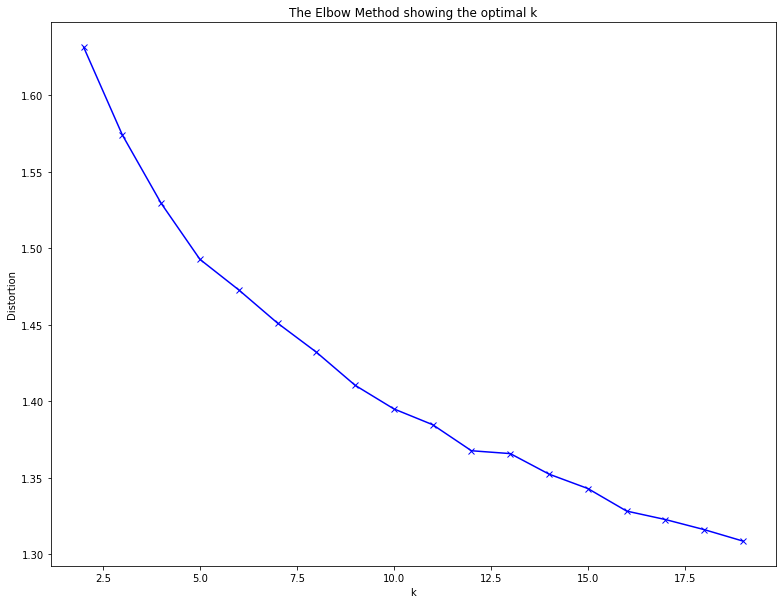

In [18]:
# k means determine k
distortions = []
K = range(2,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(recipes_filtered_df)
    kmeanModel.fit(recipes_filtered_df)
    distortions.append(sum(np.min(cdist(recipes_filtered_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / recipes_filtered_df.shape[0])

# Plot the elbow
plt.figure(figsize=(13,10))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### I try several k's to understand which clusters are the best

In [28]:
ks = [3,5,7,10,15,20]
kmeans = []
for k in ks:
    kmean = KMeans(n_clusters=k).fit(recipes_filtered_df)
    kmeans.append(kmean)
    print("\n\nTop terms per {} cluster:".format(k))
    order_centroids = kmean.cluster_centers_.argsort()[:, ::-1]
    terms = common_items
    for i in range(k):
        top_words = [terms[ind] for ind in order_centroids[i, :30]]
        print("\nCluster {}: {}".format(i, ', '.join(top_words)))



Top terms per 3 cluster:

Cluster 0: salt, vegetables, herbs, oil, water, cheese, sauce, chicken, fruits, butter, sugar, flour, vinegar, wine, rice, cream, fish, milk, pork, bread, pasta, beef, yogurt, meat, honey, ham, soda, beer, margarine, syrup

Cluster 1: vegetables, herbs, oil, sauce, cheese, chicken, sugar, water, fruits, wine, vinegar, butter, rice, cream, fish, beef, pasta, flour, bread, pork, meat, honey, milk, ham, yogurt, soda, syrup, beer, margarine, chocolate

Cluster 2: sugar, salt, butter, flour, vegetables, milk, fruits, water, herbs, cream, oil, cheese, soda, chocolate, sauce, honey, wine, syrup, vinegar, bread, chicken, yogurt, rum, rice, fish, brandy, margarine, pork, ham, pasta


Top terms per 5 cluster:

Cluster 0: sauce, vegetables, herbs, oil, sugar, salt, water, chicken, vinegar, wine, rice, fruits, fish, pork, flour, honey, butter, meat, cheese, beef, bread, cream, soda, pasta, milk, syrup, ham, yogurt, beer, rum

Cluster 1: herbs, vegetables, salt, cheese, 

### Plotting several k kmeans on pca

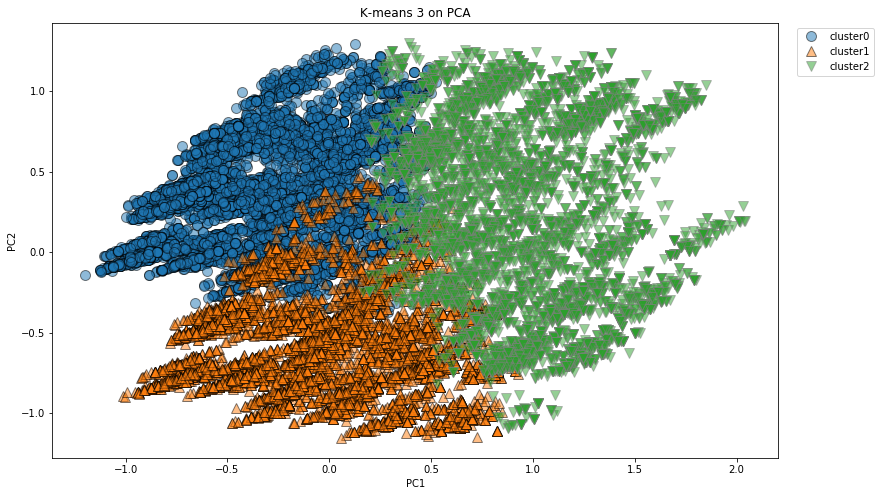

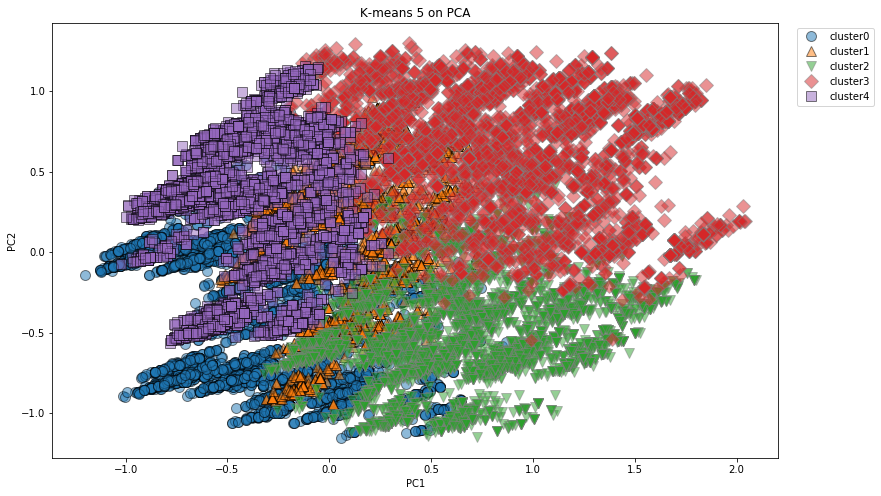

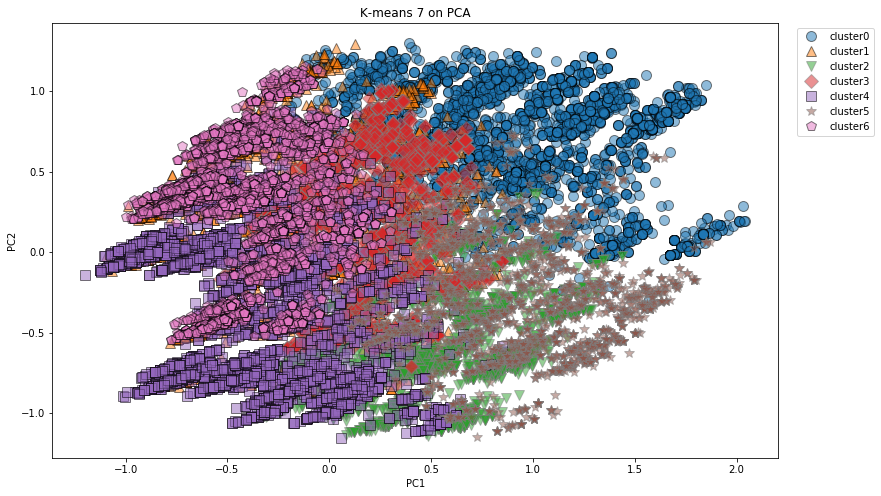

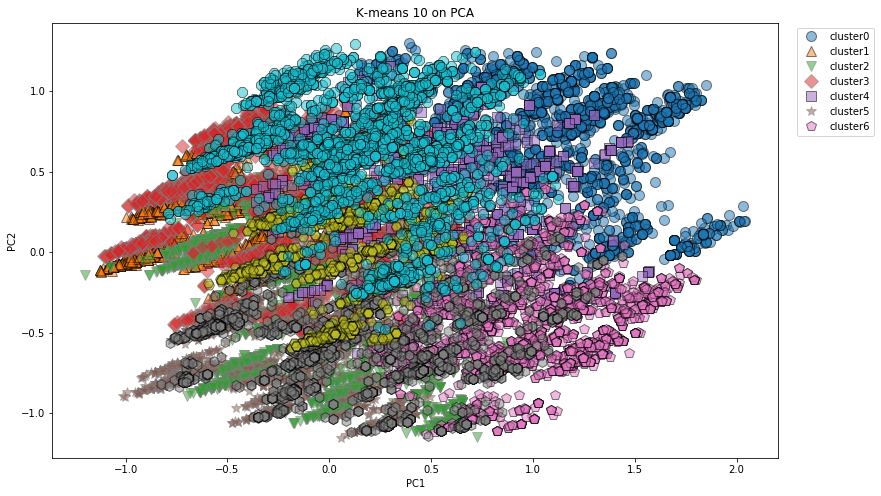

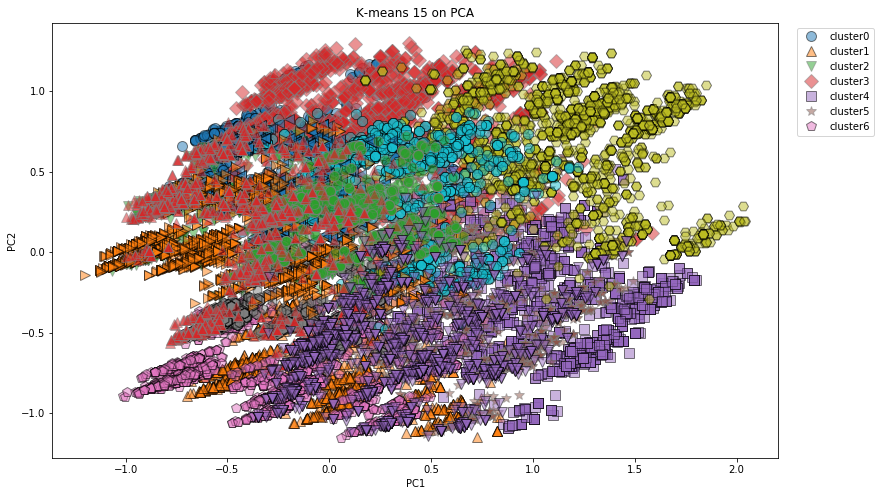

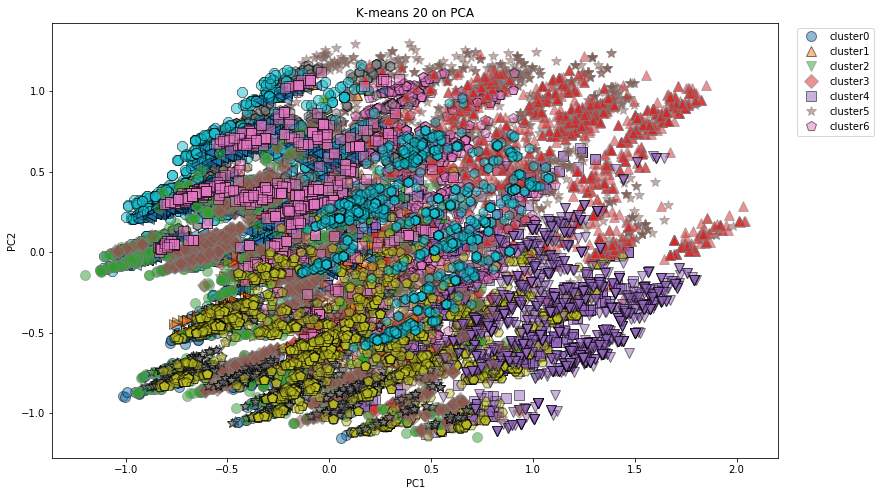

In [36]:
for i,k in enumerate(ks):
    #Plot k-means 10 clusters on PCA
    plt.figure(i,figsize=(13,8))
    mglearn.discrete_scatter(pca_sample[:,0], pca_sample[:,1], kmeans[i].labels_, alpha = 0.5)
    plt.legend(['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4',
           'cluster5', 'cluster6'], bbox_to_anchor=(1.02, 1), loc=2)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("K-means {} on PCA".format(k))
    plt.show

### Several size of dataframe

In [11]:
formatting_size = [0.3,0.5,1,2,4]
PCA_start = []
PCA_stop = []
KMEANS_start = []
KMEANS_stop = []
memory_usage = []

for i, size in enumerate(formatting_size):
    
    if(size > 1):
        temp_recipes = recipes_filtered_df.sample(frac=size, replace=True, random_state=1)
        temp_market = market_basket_df.sample(frac=size, replace=True, random_state=1)
    else:
        temp_recipes = recipes_filtered_df.sample(frac=size, random_state=1)
        temp_market = market_basket_df.sample(frac=size, random_state=1)
    memory_usage.append(temp_recipes.memory_usage(index=True).sum()/(10**6))
    
    # PCA 
    PCA_start.append(time.perf_counter())
    pca = PCA(n_components=2)
    pca_sample = pca.fit(temp_recipes).transform(temp_recipes)
    PCA_stop.append(time.perf_counter())

    # KMEANS
    KMEANS_start.append(time.perf_counter())
    k = 7
    kmeans = KMeans(n_clusters=k).fit(temp_recipes)
    predict = kmeans.predict(temp_market)
    KMEANS_stop.append(time.perf_counter()) 
    
    print("\nDataset size: {} - {} Mb".format(size, memory_usage[i]))
    print("Time Recipes PCA: {}".format(timer(PCA_start[i], PCA_stop[i])))
    print("Time Recipes KMEANS: {}".format(timer(KMEANS_start[i], KMEANS_stop[i])))
    print("Total time algorithms: {}".format(timer(PCA_start[i], KMEANS_stop[i])))


Dataset size: 0.3 - 3.23136 Mb
Time Recipes PCA: 00:00:00.05
Time Recipes KMEANS: 00:00:00.64
Total time algorithms: 00:00:00.69

Dataset size: 0.5 - 5.3856 Mb
Time Recipes PCA: 00:00:00.05
Time Recipes KMEANS: 00:00:01.14
Total time algorithms: 00:00:01.19

Dataset size: 1 - 10.770928 Mb
Time Recipes PCA: 00:00:00.12
Time Recipes KMEANS: 00:00:02.46
Total time algorithms: 00:00:02.58

Dataset size: 2 - 21.541856 Mb
Time Recipes PCA: 00:00:00.24
Time Recipes KMEANS: 00:00:04.50
Total time algorithms: 00:00:04.74

Dataset size: 4 - 43.083712 Mb
Time Recipes PCA: 00:00:00.52
Time Recipes KMEANS: 00:00:09.40
Total time algorithms: 00:00:09.92


# Apply KMeans with k=7

In [19]:
# PCA 
time_PCA_start = time.perf_counter()
pca = PCA(n_components=2)
pca_sample = pca.fit(recipes_filtered_df).transform(recipes_filtered_df)
time_PCA_stop = time.perf_counter()

# KMEANS
time_KMEANS_start = time.perf_counter()
k = 7
kmeans = KMeans(n_clusters=k).fit(recipes_filtered_df)
predict = kmeans.predict(market_basket_df)
time_KMEANS_stop = time.perf_counter()

print("Top terms per {} cluster:".format(k))
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = common_items
for i in range(k):
    top_words = [terms[ind] for ind in order_centroids[i, :34]]
    print("\nCluster {}: {}".format(i, ', '.join(top_words)))
    
print("\nTime Recipes PCA: {}".format(timer(time_PCA_start, time_PCA_stop)))
print("Time Recipes KMEANS: {}".format(timer(time_KMEANS_start, time_KMEANS_stop)))
print("Total time algorithms: {}".format(timer(time_PCA_start, time_KMEANS_stop)))

Top terms per 7 cluster:

Cluster 0: sauce, vegetables, herbs, oil, sugar, salt, vinegar, chicken, water, wine, rice, fruits, fish, pork, flour, honey, butter, meat, beef, cheese, bread, cream, soda, pasta, milk, syrup, ham, beer, yogurt, rum, brandy, margarine, chocolate

Cluster 1: water, vegetables, herbs, salt, oil, flour, cheese, butter, rice, fruits, chicken, sauce, sugar, wine, vinegar, fish, cream, beef, pork, bread, yogurt, milk, meat, pasta, honey, ham, soda, margarine, beer, syrup, chocolate, brandy, rum

Cluster 2: oil, herbs, vegetables, salt, cheese, fruits, chicken, vinegar, butter, wine, flour, cream, pasta, fish, rice, sugar, bread, yogurt, milk, meat, beef, pork, sauce, honey, ham, beer, soda, brandy, margarine, chocolate, syrup, rum, water

Cluster 3: herbs, vegetables, salt, cheese, butter, sauce, chicken, fruits, cream, rice, milk, beef, vinegar, flour, wine, sugar, bread, fish, pasta, yogurt, pork, meat, ham, honey, water, beer, margarine, syrup, brandy, soda, cho

<function matplotlib.pyplot.show(*args, **kw)>

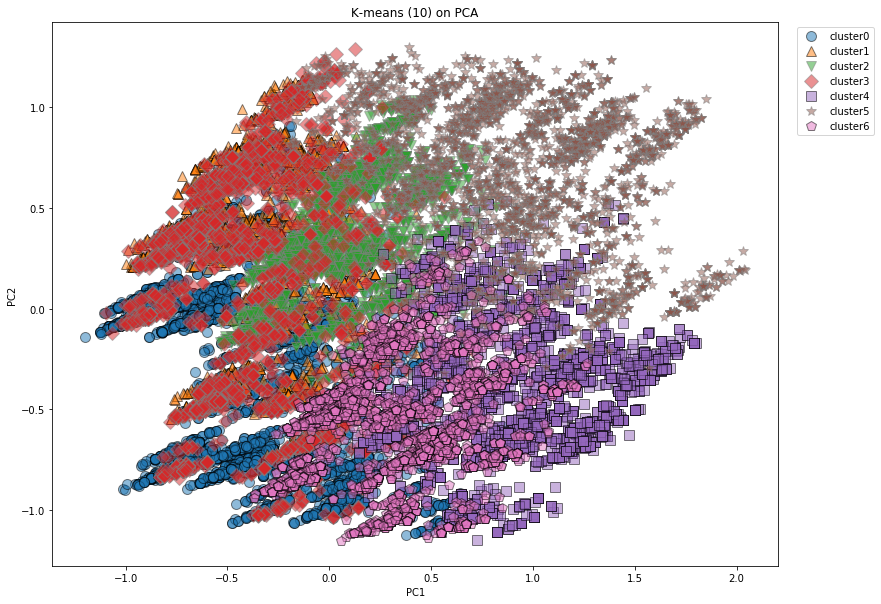

In [13]:
#Plot k-means 10 clusters on PCA
plt.figure(figsize=(13,10))
mglearn.discrete_scatter(pca_sample[:,0], pca_sample[:,1], kmeans.labels_, alpha = 0.5)
plt.legend(['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4',
       'cluster5', 'cluster6'], bbox_to_anchor=(1.02, 1), loc=2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means (7) on PCA")
plt.show

# Prediction

In [16]:
df_groceries_clean["cluster_id"] = predict

In [17]:
final_df = df_groceries_clean[["items","common_ingredients", "cluster_id"]]
final_df

items  \
0     [citrus fruit, semi-finished bread, margarine,...   
1                      [tropical fruit, yogurt, coffee]   
2                                          [whole milk]   
3       [pip fruit, yogurt, cream cheese, meat spreads]   
4     [other vegetables, whole milk, condensed milk,...   
...                                                 ...   
9830  [sausage, chicken, beef, hamburger meat, citru...   
9831                                [cooking chocolate]   
9832  [chicken, citrus fruit, other vegetables, butt...   
9833  [semi-finished bread, bottled water, soda, bot...   
9834  [chicken, tropical fruit, other vegetables, vi...   

                                     common_ingredients  cluster_id  
0                            [fruits, bread, margarine]           4  
1                                      [fruits, yogurt]           4  
2                                                [milk]           4  
3                        [fruits, yogurt, cheese, meat]           4  
4                              [vegetables, milk, milk]           6  
...                                                 ...         ...  
9830  [meat, chicken, beef, meat, fruits, vegetables...           5  
9831                                        [chocolate]           4  
9832  [chicken, fruits, vegetables, butter, yogurt, ...           6  
9833                         [bread, water, soda, beer]           4  
9834             [chicken, fruits, vegetables, vinegar]           6  

[8950 rows x 3 columns]